In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
from math import sqrt, fabs, log
import pandas as pd
import SimTools



Welcome to JupyROOT 6.18/00


In [2]:
# dataframe containg all data
df = pd.read_pickle("./MS_fitting_data.pk")

# dataframe for fitting data
# here we impose sigma < 15 deg
df_fit = df.loc[df.sigma < 15.0].reset_index(drop=True)
df_fit.head()

,gas,energy,fit_length,ang_dist,sigma,sigma_err
0,cf4,200,0.5,"[0.19745657510837264, -0.32102103492227574, 0....",9.137771,0.073639
1,cf4,200,1.0,"[0.3852299696498778, -0.3025206673851232, 0.42...",13.686588,0.109659
2,cf4,300,0.5,"[0.22638431897651873, -0.00015887808223294644,...",6.392045,0.051391
3,cf4,300,1.0,"[0.3537478147723615, 0.23375465215118296, 0.00...",9.560468,0.075920
4,cf4,300,2.0,"[0.34439899830572857, 0.34681683747590825, -0....",14.488935,0.115898


In [3]:
# Collect info for fitting MS models
E = []
x = []
X_o = []
Y = []
err = []

for index, row in df_fit.iterrows():

    E += [ (1.0*row.energy )/1000.0 ]   # convert energy to MeV
    x += [row.fit_length/100.0]         # convert fit length to m
    X_o += [SimTools.Rad_Lengths[row.gas]]
    Y += [row.sigma]
    err += [row.sigma_err]



In [4]:
# Fit the Highland formula
popt_Hfit, pcov_Hfit = curve_fit(SimTools.highland_fit , (E,x,X_o), Y, sigma=err, absolute_sigma=True)
perr_Hfit = np.sqrt(np.diag(pcov_Hfit))

print("Highland fit:")
print("S_2 = ", popt_Hfit[0], "+/-", perr_Hfit[0])
print("eps = ", popt_Hfit[1], "+/-", perr_Hfit[1])


# Fit Rossi formula
popt_Rfit, pcov_Rfit = curve_fit(SimTools.rossi_fit, (E,x,X_o), Y, sigma=err, absolute_sigma=True)
perr_Rfit = np.sqrt(np.diag(pcov_Rfit))

print("Rossi fit:")
print("S_2 = ", popt_Rfit[0], "+/-", perr_Rfit[0])


Highland fit:
S_2 =  7.570477850506444 +/- 0.06730158171501456
eps =  -0.07843846922226548 +/- 0.0016297501269118195
Rossi fit:
S_2 =  13.179993284537826 +/- 0.0076338903035232525


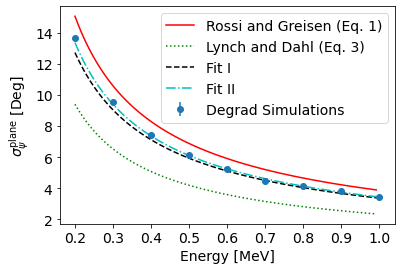

In [5]:
# Plot an example of the fits and original formulas
select_gas = "cf4"
fit_lenght = 1.0 

df_plot = df_fit.loc[ (df_fit.gas == select_gas) &  (df_fit.fit_length == fit_lenght)]




energy = df_plot["energy"]/1000.0
fit_len = fit_lenght/100.0
rad_l = SimTools.Rad_Lengths[select_gas]

plt.errorbar(energy, df_plot["sigma"], yerr=df_plot["sigma_err"], fmt='o',  label='Degrad Simulations')


Es = np.arange(min(energy),max(energy), (max(energy)-min(energy))/100)

Eq1 = [ SimTools.rossi_fit( (E, fit_len, rad_l) , 14.849 ) for E in Es] 
Eq3 = [ SimTools.highland_fit( (E, fit_len, rad_l) , 13.6, 0.038 ) for E in Es]
fit1 = [SimTools.highland_fit( (E, fit_len, rad_l) , popt_Hfit[0], popt_Hfit[1] ) for E in Es]
fit2 = [ SimTools.rossi_fit( (E, fit_len, rad_l) , popt_Rfit[0] ) for E in Es] 


plt.plot(Es, Eq1, 'r-', label='Rossi and Greisen (Eq. 1)')
plt.plot(Es, Eq3, 'g:', label='Lynch and Dahl (Eq. 3)')
plt.plot(Es, fit1, 'k--', label='Fit I')
plt.plot(Es, fit2, 'c-.', label='Fit II')


plt.legend(fontsize=14)
plt.xlabel("Energy [MeV]",fontsize=14)
plt.ylabel("$\\sigma_\\psi^{\\rm plane}$ [Deg]",fontsize=14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.savefig("../figures/fit_models.pdf",bbox_inches='tight')




In [6]:
# Estimate uncertainty on Rossi fit paramters by looking at the standard deviation of the fit result by fitting to each gas individually

S2_vals = []

for gas in df_fit["gas"].unique():

    df_gas = df_fit.loc[ df_fit["gas"] == gas].reset_index(drop=True)

    # Collect info for fitting MS models
    E = []
    x = []
    X_o = []
    Y = []
    err = []

    for index, row in df_gas.iterrows():

        E += [ (1.0*row.energy )/1000.0 ]   # convert energy to MeV
        x += [row.fit_length/100.0]         # convert fit length to m
        X_o += [SimTools.Rad_Lengths[row.gas]]
        Y += [row.sigma]
        err += [row.sigma_err]

    # Fit Rossi formula
    popt, pcov = curve_fit(SimTools.rossi_fit, (E,x,X_o), Y, sigma=err, absolute_sigma=True)
    perr = np.sqrt(np.diag(pcov))

    S2_vals += [popt[0]]

S2_std = np.std(S2_vals)

print("Standard devation in S2: ", S2_std)

Standard devation in S2:  1.5931048725151404


In [7]:
# Save all data

# initialize list of lists
data = [['Highland_S2', popt_Hfit[0]], ['Highland_S2_err', perr_Hfit[0]], ['Highland_eps', popt_Hfit[1]], ['Highland_eps_err',perr_Hfit[1]], ['Rossi_S2', popt_Rfit[0]], ['Rossi_S2_err', perr_Rfit[0]], ['Rossi_S2_std', S2_std] ]
 
# Create the pandas DataFrame
df_save = pd.DataFrame(data, columns=['Name', 'Value'])


df_save.to_pickle("./MS_fitting_results.pk")

df_save 

,Name,Value
0,Highland_S2,7.570478
1,Highland_S2_err,0.067302
2,Highland_eps,-0.078438
3,Highland_eps_err,0.001630
4,Rossi_S2,13.179993
5,Rossi_S2_err,0.007634
6,Rossi_S2_std,1.593105
